# Anomaly Detection

## 1. Isolation Forests

### a. Data Prep

In [1]:
# read in the entertainment data
import pandas as pd

df = pd.read_csv('../Data/entertainment_clean.csv')
df.head()

,name,books,tv_shows,video_games
0,Aaliyah,0.5,4.6,4.9
1,Abigail,0.0,4.5,4.8
2,Addison,0.5,4.5,5.0
3,Adeline,3.5,4.5,6.6
4,Alana,2.8,3.8,5.6


In [2]:
# keep only the numeric columns
X = df.iloc[:, 1:]
X.head()

,books,tv_shows,video_games
0,0.5,4.6,4.9
1,0.0,4.5,4.8
2,0.5,4.5,5.0
3,3.5,4.5,6.6
4,2.8,3.8,5.6


In [3]:
# note the shape of the data
X.shape

(150, 3)

### b. Fit an Isolation Forest Model

In [4]:
# import isolation forest from sklearn
from sklearn.ensemble import IsolationForest

In [5]:
# fit an isolation forest model with 2% of the data set as anomalies
model = IsolationForest(contamination=0.02)
model.fit(X)

IsolationForest(contamination=0.02)

In [6]:
# view the anomaly scores
df['anomaly_scores'] = model.decision_function(X)
df.sort_values('anomaly_scores').head()

,name,books,tv_shows,video_games,anomaly_scores
110,Octavia,5.0,5.7,7.9,-0.029195
15,Avery,1.0,6.6,5.7,-0.002432
147,Zara,5.5,5.7,7.7,-0.002150
37,Elena,0.8,3.4,4.5,0.000044
58,Hailey,2.5,3.0,5.0,0.015349


In [7]:
# view the anomaly flags
df['anomaly'] = model.predict(X)
df.sort_values('anomaly_scores').head(10)

,name,books,tv_shows,video_games,anomaly_scores,anomaly
110,Octavia,5.0,5.7,7.9,-0.029195,-1
15,Avery,1.0,6.6,5.7,-0.002432,-1
147,Zara,5.5,5.7,7.7,-0.002150,-1
37,Elena,0.8,3.4,4.5,0.000044,1
58,Hailey,2.5,3.0,5.0,0.015349,1
19,Bianca,5.8,3.9,7.7,0.022316,1
29,Clementine,6.2,5.4,7.2,0.024312,1
148,Zoe,0.0,6.1,5.2,0.027644,1
42,Elizabeth,0.0,4.5,4.3,0.041155,1
109,Nora,0.5,6.3,5.5,0.065173,1


### c. Visualize the Anomalies

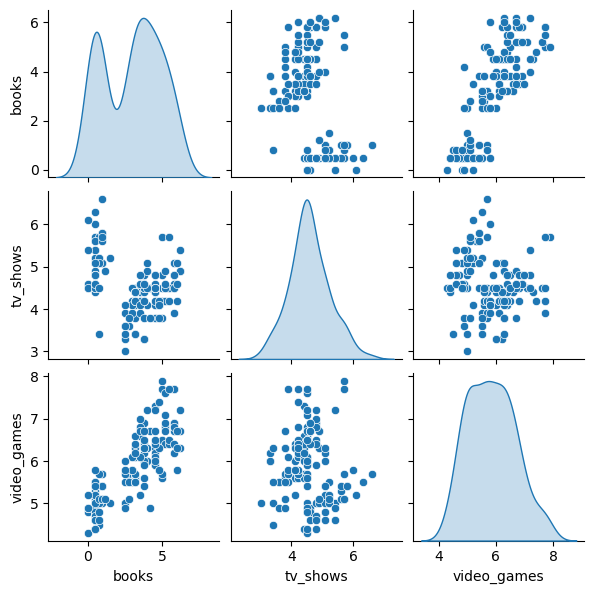

In [8]:
# view a pair plot of the original data set
import seaborn as sns

sns.pairplot(X, diag_kind='kde', height=2);

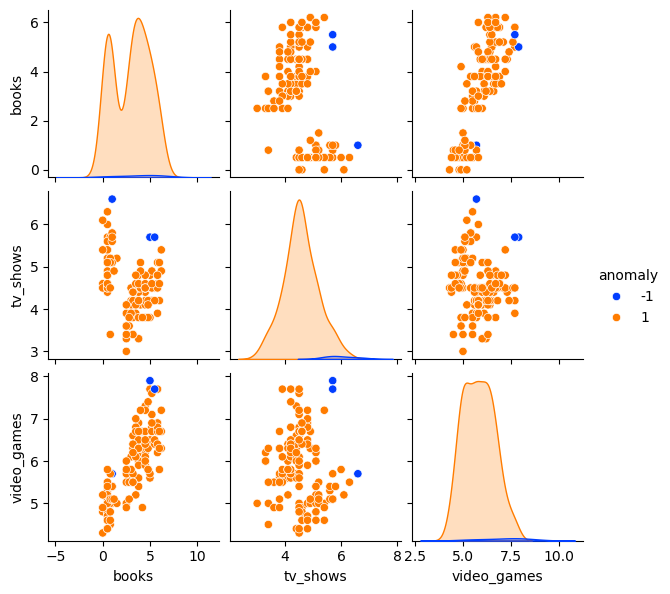

In [9]:
# overlay the isolation forest detected outliers
sns.pairplot(df.drop(columns='anomaly_scores'), hue='anomaly', palette='bright', height=2);

### d. Tune the Model

In [10]:
# update the model to flag 5% of rows as anomalies
model5 = IsolationForest(contamination=0.05)
model5.fit(X)

IsolationForest(contamination=0.05)

In [11]:
# view the anomaly scores
df['anomaly_scores_5'] = model5.decision_function(X)
df.sort_values('anomaly_scores_5').head()

,name,books,tv_shows,video_games,anomaly_scores,anomaly,anomaly_scores_5
110,Octavia,5.0,5.7,7.9,-0.029195,-1,-0.070454
37,Elena,0.8,3.4,4.5,0.000044,1,-0.041627
147,Zara,5.5,5.7,7.7,-0.002150,-1,-0.038036
29,Clementine,6.2,5.4,7.2,0.024312,1,-0.027333
148,Zoe,0.0,6.1,5.2,0.027644,1,-0.019633


In [12]:
# view the anomaly flags
df['anomaly_5'] = model5.predict(X)
df.sort_values('anomaly_5').head(10)

,name,books,tv_shows,video_games,anomaly_scores,anomaly,anomaly_scores_5,anomaly_5
19,Bianca,5.8,3.9,7.7,0.022316,1,-0.015561,-1
147,Zara,5.5,5.7,7.7,-0.002150,-1,-0.038036,-1
148,Zoe,0.0,6.1,5.2,0.027644,1,-0.019633,-1
37,Elena,0.8,3.4,4.5,0.000044,1,-0.041627,-1
110,Octavia,5.0,5.7,7.9,-0.029195,-1,-0.070454,-1
15,Avery,1.0,6.6,5.7,-0.002432,-1,-0.018937,-1
42,Elizabeth,0.0,4.5,4.3,0.041155,1,-0.008877,-1
29,Clementine,6.2,5.4,7.2,0.024312,1,-0.027333,-1
98,Melody,3.2,4.4,6.4,0.213328,1,0.173344,1
99,Mia,0.5,5.1,5.0,0.238798,1,0.196948,1


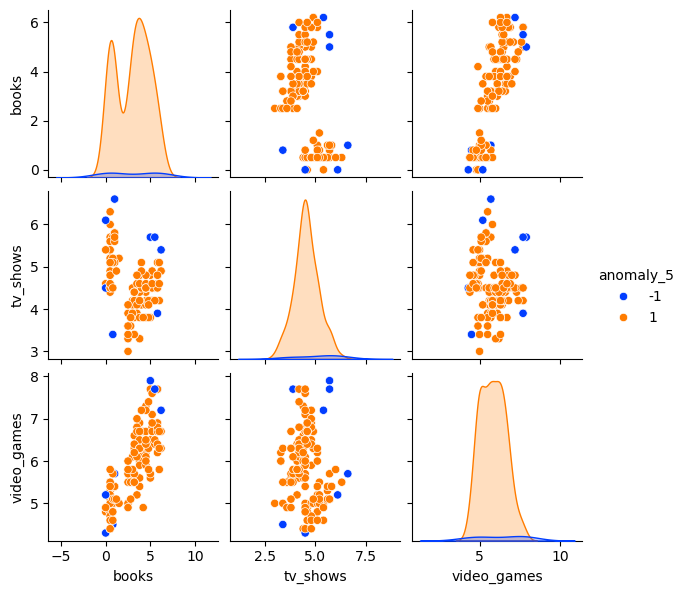

In [13]:
# overlay the isolation forest detected outliers
sns.pairplot(df.drop(columns=['anomaly_scores', 'anomaly', 'anomaly_scores_5']), hue='anomaly_5', palette='bright', height=2);

## 2. DBSCAN

### a. Fit a DBSCAN Model

In [14]:
# view the data (columns already on similar scales)
X.head()

,books,tv_shows,video_games
0,0.5,4.6,4.9
1,0.0,4.5,4.8
2,0.5,4.5,5.0
3,3.5,4.5,6.6
4,2.8,3.8,5.6


In [15]:
# dbscan function (copied from clustering section) to find a good eps + min_samples combo
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def tune_dbscan(data):

    results = []

    # define a range of eps and min_samples values to loop through
    eps_values = np.arange(.1, 2, .1)
    min_samples_values = np.arange(2, 10, 1)

    # loop through the combinations of eps and min_samples
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(data)
            labels = dbscan.labels_

            # count the number of clusters (excluding noise points labeled as -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # count the number of noise points (labeled as -1)
            n_noise = list(labels).count(-1)

            # calculate the silhouette score (excluding noise points)
            if n_clusters > 1:  # silhouette score requires at least 2 clusters
                silhouette = silhouette_score(data, labels, metric='euclidean', sample_size=None)
            else:
                silhouette = None

            results.append([eps, min_samples, n_clusters, n_noise, silhouette])

    # put the results in a dataframe
    dbscan_results = pd.DataFrame(results, columns=["Eps", "Min Samples", "Number of Clusters",
                                                    "Number of Noise Points", "Silhouette Score"])
    return dbscan_results

In [16]:
# view the results on the original data
dbscan_results = tune_dbscan(X)
dbscan_results.head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
0,0.1,2,12,124,-0.438782
1,0.1,3,2,144,-0.483479
2,0.1,4,0,150,NaN
3,0.1,5,0,150,NaN
4,0.1,6,0,150,NaN


In [17]:
# top silhouette scores
dbscan_results.sort_values(by='Silhouette Score', ascending=False).head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
127,1.6,9,2,0,0.628673
109,1.4,7,2,0,0.628673
107,1.4,5,2,0,0.628673
106,1.4,4,2,0,0.628673
105,1.4,3,2,0,0.628673


In [18]:
# return one eps + min_samples combo for each silhouette score
(dbscan_results.sort_values('Silhouette Score', ascending=False)
               .groupby('Silhouette Score')
               .head(1)).head(10)

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
127,1.6,9,2,0,0.628673
76,1.0,6,2,2,0.550831
79,1.0,9,2,3,0.528540
72,1.0,2,2,1,0.515323
57,0.8,3,2,4,0.497686
62,0.8,8,2,5,0.482653
43,0.6,5,2,12,0.480329
52,0.7,6,2,9,0.476795
41,0.6,3,2,11,0.476287
63,0.8,9,2,6,0.471959


In [19]:
# fit a dbscan model
dbscan = DBSCAN(eps=1, min_samples=6)
dbscan.fit(X)

DBSCAN(eps=1, min_samples=6)

In [20]:
# view the cluster assignments
dbscan.labels_

array([ 0,  0,  0,  1,  1,  1,  1,  1,  0,  1,  1,  0,  0,  0,  0,  0,  1,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  0,  1,  1,  1,  0,  0,  1,  1,  0,  1,  0,  1,  1,
        1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  0,  0,  1,  1,  1,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        1,  1,  0,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0,
        1,  1,  1,  1,  0,  1,  0,  0, -1,  1,  0,  0,  0,  1,  1,  0,  1,
        1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  1,  0,  1,  1,
        1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0])

### b. Visualize the Anomalies

In [21]:
# view the anomaly labels
df.head()

,name,books,tv_shows,video_games,anomaly_scores,anomaly,anomaly_scores_5,anomaly_5
0,Aaliyah,0.5,4.6,4.9,0.218873,1,0.168493,1
1,Abigail,0.0,4.5,4.8,0.119245,1,0.082886,1
2,Addison,0.5,4.5,5.0,0.209338,1,0.159553,1
3,Adeline,3.5,4.5,6.6,0.205095,1,0.176519,1
4,Alana,2.8,3.8,5.6,0.189365,1,0.154742,1


In [22]:
# view the anomaly labels from dbscan
df['anomaly_dbscan'] = dbscan.labels_
df.head()

,name,books,tv_shows,video_games,anomaly_scores,anomaly,anomaly_scores_5,anomaly_5,anomaly_dbscan
0,Aaliyah,0.5,4.6,4.9,0.218873,1,0.168493,1,0
1,Abigail,0.0,4.5,4.8,0.119245,1,0.082886,1,0
2,Addison,0.5,4.5,5.0,0.209338,1,0.159553,1,0
3,Adeline,3.5,4.5,6.6,0.205095,1,0.176519,1,1
4,Alana,2.8,3.8,5.6,0.189365,1,0.154742,1,1


In [23]:
# view specific anomalies
df[df['anomaly_dbscan'] == -1]

,name,books,tv_shows,video_games,anomaly_scores,anomaly,anomaly_scores_5,anomaly_5,anomaly_dbscan
37,Elena,0.8,3.4,4.5,0.000044,1,-0.041627,-1,-1
110,Octavia,5.0,5.7,7.9,-0.029195,-1,-0.070454,-1,-1


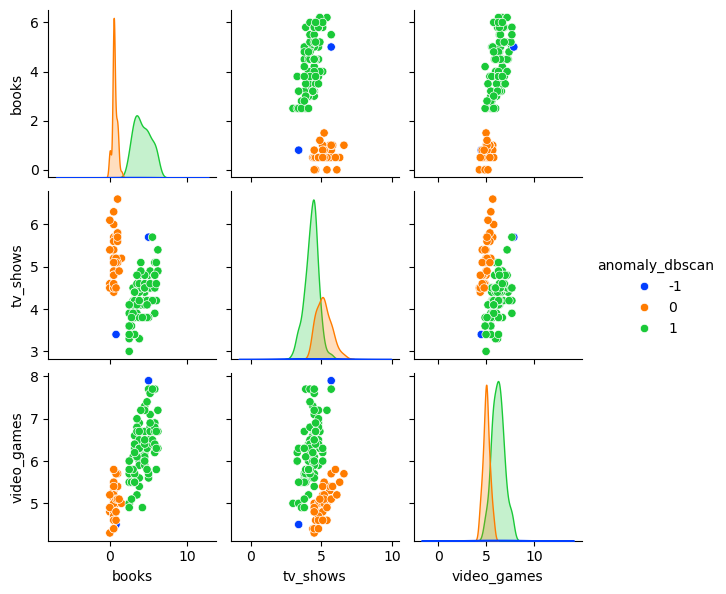

In [24]:
# create a pair plot
sns.pairplot(df[['books', 'tv_shows', 'video_games', 'anomaly_dbscan']], hue='anomaly_dbscan', palette='bright', height=2);